In [709]:
# Importnado bibliotecas e módulos necessários

import pandas as pd # Pandas para manipulação de dataframes
from dfply import * # Importação dos módulos necessário para trabalhar com pipe em Python
import numpy as np # Operações matemáticas
import matplotlib.dates

# Visualização dos dados
import seaborn as sns 
import matplotlib.pyplot as plt
# Evitar ficar usando plt.show()
%matplotlib inline

In [710]:
# Configurações globais
sns.set_style('white') # background
sns.set_context('paper', font_scale=1.5) # Formato artigo
sns.set_palette("deep")
plt.tight_layout()
# Parametros e rcParams vai setar configurações globais para os gráficos, ela serve também como mecanismo de controle
parametros = {'legend.fontsize': 15,
          'figure.figsize': (15,8)}
plt.rcParams.update(parametros)

<Figure size 432x288 with 0 Axes>

In [711]:
df = pd.read_csv('http://tecgeobr.com.br/csv/joao_pessoa/Dados20082020.csv',encoding = "ISO-8859-1", sep = ';' )

In [712]:
df.head()

,DT_NOTIFIC,SE_NOTIF,SG_SRAG,DT_SIN_PRI,SE_SINT,CS_SEXO,DT_NASC,NU_IDADE_N,NM_BAIRRO,ZONA_EPI,MUN_RES,RESULTADO,STATUS_DO_PACIENTE,DT_OBITO
0,02/06/2020,23,SG,11/05/2020,20,M,04/10/2017,2,JOAO PAULO II,SUDOESTE,JOAO PESSOA,CORONAVIRUS,RECUPERADO,NaN
1,01/07/2020,27,SG,27/06/2020,26,M,07/06/1978,42,ALTO DO CEU,NOROESTE,JOAO PESSOA,CORONAVIRUS,NaN,NaN
2,01/06/2020,23,SRAG,28/05/2020,22,M,05/06/2006,14,BAIRRO DOS ESTADOS,NORDESTE,JOAO PESSOA,CORONAVIRUS,RECUPERADO,NaN
3,04/05/2020,19,SRAG,25/04/2020,17,M,18/05/1969,51,VARADOURO,NOROESTE,JOAO PESSOA,CORONAVIRUS,OBITO CONFIRMADO,06/05/2020
4,12/06/2020,24,SG,12/06/2020,24,F,11/02/2002,18,SAO JOSE,NORDESTE,JOAO PESSOA,CORONAVIRUS,RECUPERADO,NaN


In [713]:
df.RESULTADO.unique()

array(['CORONAVIRUS', 'DESCARTADO', nan, 'EM INVESTIGACAO', 'INFLUENZA B',
       'H1N1'], dtype=object)

# Preparando base de dados

In [714]:
df.STATUS_DO_PACIENTE = df.STATUS_DO_PACIENTE.fillna('Não Informado')
df.ZONA_EPI = df.ZONA_EPI.fillna('Não Informado')
df.RESULTADO = df.RESULTADO.fillna('Não Informado')

# Ajustando datas

In [715]:
df.DT_OBITO = pd.to_datetime(df.DT_OBITO, format= '%d/%m/%Y')
df.DT_NOTIFIC = pd.to_datetime(df.DT_NOTIFIC, format= '%d/%m/%Y')
df.DT_SIN_PRI = pd.to_datetime(df.DT_SIN_PRI, format= '%d/%m/%Y')

# Óbitos

In [716]:
df['STATUS_DO_PACIENTE'].unique()

array(['RECUPERADO', 'Não Informado', 'OBITO CONFIRMADO', 'DESCARTADO',
       'OBITO DESCARTADO', 'OBITO EM INVESTIGACAO', 'EM INVESTIGACAO',
       'ISOLAMENTO DOMICILIAR', 'ISOLAMENTO HOSPITALAR', 'UTI'],
      dtype=object)

In [717]:
obitos = (
    df >> arrange(X.DT_OBITO, ascending=True) >>
    mask(X.STATUS_DO_PACIENTE == 'OBITO CONFIRMADO') >> 
    group_by('DT_OBITO') >> 
    summarize(quantidade = n(X.DT_OBITO)) >>
    ungroup() >>
    mutate(mme_5 = X.quantidade.ewm(span=5, adjust=False).mean())
)

obitos.index = obitos.DT_OBITO

In [718]:
obitos.head()

,DT_OBITO,quantidade,mme_5
DT_OBITO,,,
2020-03-16,2020-03-16,1,1.000000
2020-03-19,2020-03-19,1,1.000000
2020-03-23,2020-03-23,1,1.000000
2020-03-24,2020-03-24,1,1.000000
2020-03-29,2020-03-29,2,1.333333


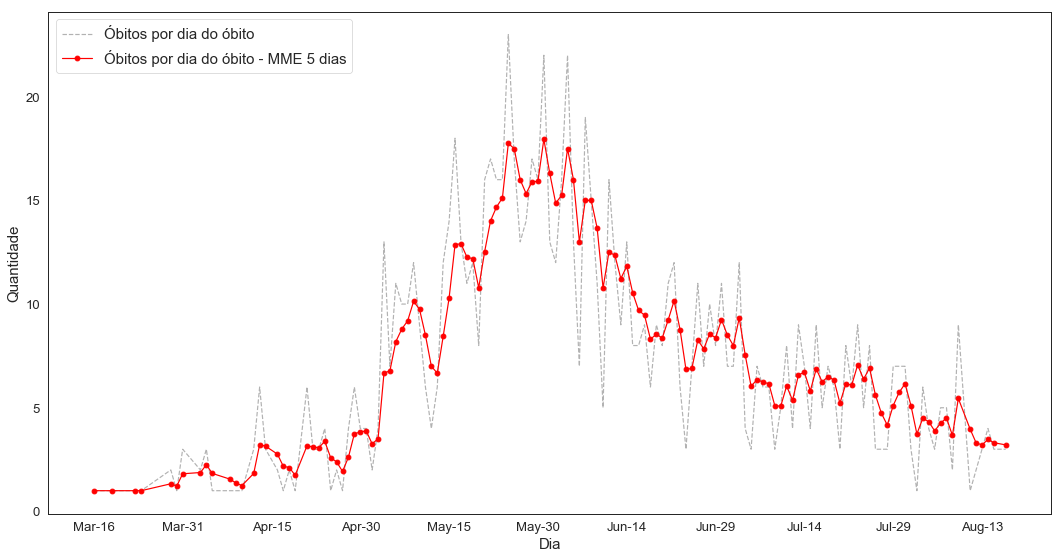

In [719]:
# Visualizando
fig, ax1 = plt.subplots()

ax1.set_xlabel('Dia', fontsize = 15) # Eixo x
ax1.set_ylabel('Quantidade', fontsize = 15) # Eixo y
ax1.plot(obitos.index, obitos.quantidade, 'k--', alpha = 0.3, label = 'Óbitos por dia do óbito') # gráfico de linha
ax1.plot(obitos.index, obitos.mme_5, 'r-o', label = 'Óbitos por dia do óbito - MME 5 dias') # gráfico de linha
ax1.legend(loc = 'upper left') # Caso queira que isso seja decidido automaticamente, mudar o valor do atributo para 'best'


ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax1.xaxis.set_major_locator(plt.MaxNLocator(15)) # Define a quantidade de label


fig.tight_layout()  # Ajusta layout, últil para salvar os gráficos sem correr o perigo de cortar informações

fig.savefig('Imagens/mortes_jp.png')

# Recuperados

In [720]:
df.columns

Index(['DT_NOTIFIC', 'SE_NOTIF', 'SG_SRAG', 'DT_SIN_PRI', 'SE_SINT', 'CS_SEXO',
       'DT_NASC', 'NU_IDADE_N', 'NM_BAIRRO', 'ZONA_EPI', 'MUN_RES',
       'RESULTADO', 'STATUS_DO_PACIENTE', 'DT_OBITO'],
      dtype='object')

In [753]:
recup = (
    df >> arrange(X.DT_NOTIFIC, ascending=True) >>
    mask(X.STATUS_DO_PACIENTE == 'RECUPERADO') >> 
    group_by('DT_NOTIFIC') >> 
    summarize(quantidade = n(X.STATUS_DO_PACIENTE)) >>
    ungroup() >>
    mutate(mme_5 = X.quantidade.ewm(span=5, adjust=False).mean())
)

recup.index = recup.DT_NOTIFIC
recup >>= drop(X.DT_NOTIFIC)
recup.tail()

,quantidade,mme_5
DT_NOTIFIC,,
2020-08-06,7,13.695366
2020-08-07,8,11.796910
2020-08-10,1,8.197940
2020-08-11,11,9.131960
2020-08-13,1,6.421307


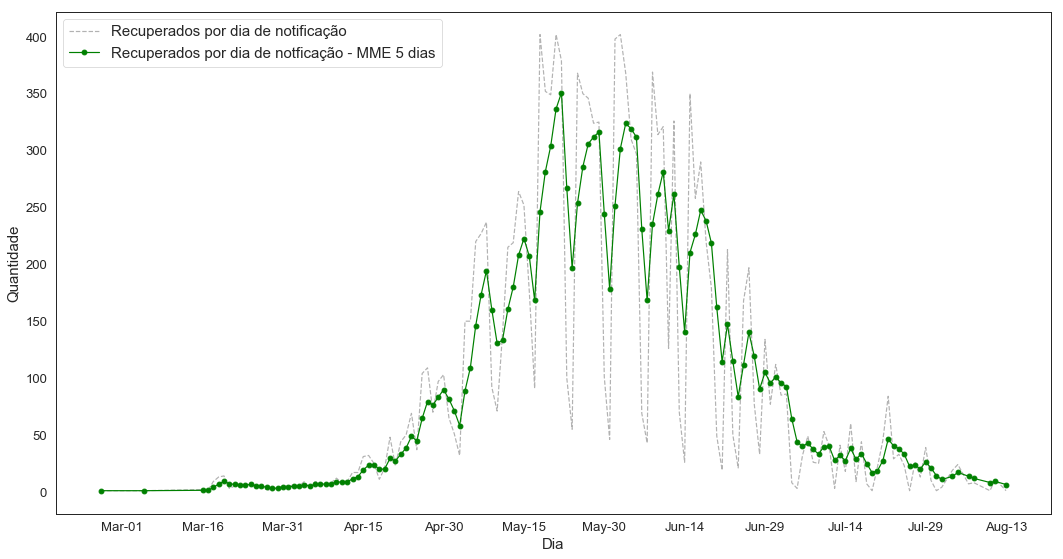

In [754]:
# Visualizando
fig, ax1 = plt.subplots()

ax1.set_xlabel('Dia', fontsize = 15) # Eixo x
ax1.set_ylabel('Quantidade', fontsize = 15) # Eixo y
ax1.plot(recup.index, recup.quantidade, 'k--', alpha = 0.3, label = 'Recuperados por dia de notificação') # gráfico de linha
ax1.plot(recup.index, recup.mme_5, 'g-o', label = 'Recuperados por dia de notficação - MME 5 dias') # gráfico de linha
ax1.legend(loc = 'upper left') # Caso queira que isso seja decidido automaticamente, mudar o valor do atributo para 'best'


ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax1.xaxis.set_major_locator(plt.MaxNLocator(15)) # Define a quantidade de label


fig.tight_layout()  # Ajusta layout, últil para salvar os gráficos sem correr o perigo de cortar informações

fig.savefig('Imagens/recuperados_jp.png')

# Ativos

In [723]:
df.STATUS_DO_PACIENTE.unique()

array(['RECUPERADO', 'Não Informado', 'OBITO CONFIRMADO', 'DESCARTADO',
       'OBITO DESCARTADO', 'OBITO EM INVESTIGACAO', 'EM INVESTIGACAO',
       'ISOLAMENTO DOMICILIAR', 'ISOLAMENTO HOSPITALAR', 'UTI'],
      dtype=object)

In [724]:
# Total
total = (
        df >>  mask((X.STATUS_DO_PACIENTE != 'DESCARTADO') & 
             (X.STATUS_DO_PACIENTE != 'OBITO DESCARTADO') & 
             (X.STATUS_DO_PACIENTE != 'OBITO EM INVESTIGACAO') &
             (X.STATUS_DO_PACIENTE != 'EM INVESTIGACAO')) >>
        arrange(X.DT_NOTIFIC, ascending=True) >>
        group_by('DT_NOTIFIC') >> 
        summarize(quantidade_t = n(X.DT_NOTIFIC)) >>
        ungroup() >>
        mutate(mme_5_t = X.quantidade_t.ewm(span=5, adjust=False).mean())
)

total.tail()

,DT_NOTIFIC,quantidade_t,mme_5_t
163,2020-08-13,16,41.933595
164,2020-08-14,15,32.955730
165,2020-08-17,2,22.637153
166,2020-08-18,2,15.758102
167,2020-08-19,1,10.838735


In [725]:
obito_notificacao = (
        df >> arrange(X.DT_NOTIFIC, ascending=True) >>
        mask(X.STATUS_DO_PACIENTE == 'OBITO CONFIRMADO') >> 
        group_by('DT_NOTIFIC') >> 
        summarize(quantidade = n(X.DT_NOTIFIC)) >>
        ungroup() >>
        mutate(mme_5 = X.quantidade.ewm(span=5, adjust=False).mean())
)

#obito_notificacao.index = obito_notificacao.DT_NOTIFIC
#obito_notificacao >>= drop(X.DT_NOTIFIC)
obito_notificacao.tail()

,DT_NOTIFIC,quantidade,mme_5
133,2020-08-11,2,2.403109
134,2020-08-12,1,1.935406
135,2020-08-13,3,2.290271
136,2020-08-18,2,2.193514
137,2020-08-19,1,1.795676


In [726]:
# Juntando base de dados
ativos = recup >> full_join(obito_notificacao, by = 'DT_NOTIFIC') >> full_join(total, by = 'DT_NOTIFIC')

# Tirando os NaN
ativos.quantidade_x = ativos.quantidade_x.fillna(0)
ativos.quantidade_y = ativos.quantidade_y.fillna(0)
ativos.quantidade_t = ativos.quantidade_t.fillna(0)

ativos >>= arrange(X.DT_NOTIFIC, ascending = True)
ativos >>= mutate(rec_acu = cumsum(X.quantidade_x)) >> mutate(obitos_acu = cumsum(X.quantidade_y)) >> mutate(total = cumsum(X.quantidade_t))
ativos >>= mutate(ativos = X.total - X.rec_acu - X.obitos_acu)

ativos.index = ativos.DT_NOTIFIC

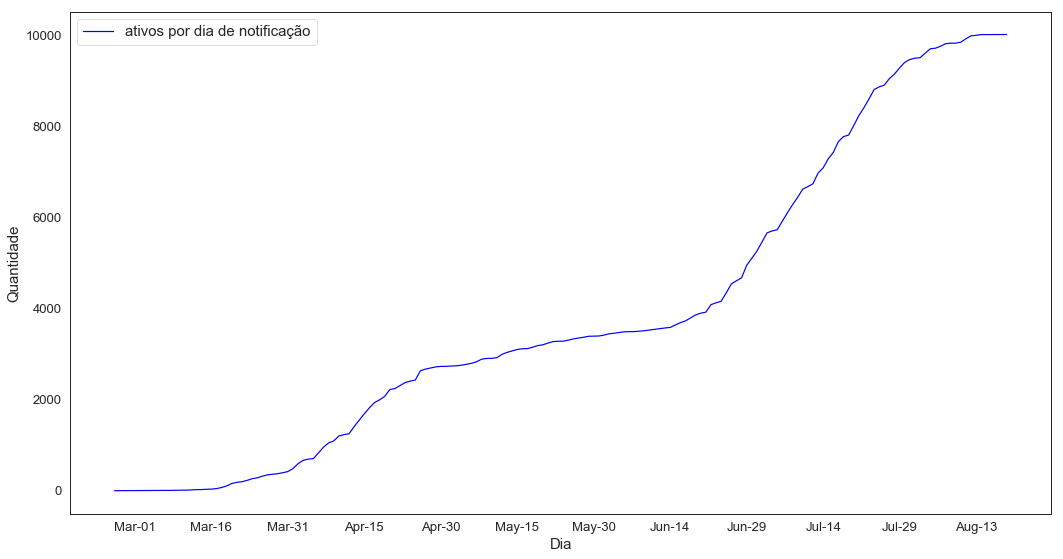

In [727]:
# Visualizando
fig, ax1 = plt.subplots()

ax1.set_xlabel('Dia', fontsize = 15) # Eixo x
ax1.set_ylabel('Quantidade', fontsize = 15) # Eixo y
ax1.plot(ativos.index, ativos.ativos, 'b-', label = 'ativos por dia de notificação') # gráfico de linha
#ax1.plot(ativos.index, ativos.mme_5, 'g-o', label = 'ativoserados por dia de notficação - MME 5 dias') # gráfico de linha
ax1.legend(loc = 'upper left') # Caso queira que isso seja decidido automaticamente, mudar o valor do atributo para 'best'


ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax1.xaxis.set_major_locator(plt.MaxNLocator(15)) # Define a quantidade de label


fig.tight_layout()  # Ajusta layout, últil para salvar os gráficos sem correr o perigo de cortar informações

fig.savefig('Imagens/ativos_jp.png')

# Função para anotações

In [728]:
### Funções

def coloca_anotacoes(graf, df, coluna = 0, local = 0, corrige = 0):
    i=0 + corrige
    for p in graf.patches:
        height = p.get_height()
        graf.text(p.get_x()+p.get_width()/2., height + local,
            str(df[coluna].iloc[i]),ha="center", fontsize = 15)
        i += 1

# Status dos Pacientes

In [729]:
df.head()

,DT_NOTIFIC,SE_NOTIF,SG_SRAG,DT_SIN_PRI,SE_SINT,CS_SEXO,DT_NASC,NU_IDADE_N,NM_BAIRRO,ZONA_EPI,MUN_RES,RESULTADO,STATUS_DO_PACIENTE,DT_OBITO
0,2020-06-02,23,SG,2020-05-11,20,M,04/10/2017,2,JOAO PAULO II,SUDOESTE,JOAO PESSOA,CORONAVIRUS,RECUPERADO,NaT
1,2020-07-01,27,SG,2020-06-27,26,M,07/06/1978,42,ALTO DO CEU,NOROESTE,JOAO PESSOA,CORONAVIRUS,Não Informado,NaT
2,2020-06-01,23,SRAG,2020-05-28,22,M,05/06/2006,14,BAIRRO DOS ESTADOS,NORDESTE,JOAO PESSOA,CORONAVIRUS,RECUPERADO,NaT
3,2020-05-04,19,SRAG,2020-04-25,17,M,18/05/1969,51,VARADOURO,NOROESTE,JOAO PESSOA,CORONAVIRUS,OBITO CONFIRMADO,2020-05-06
4,2020-06-12,24,SG,2020-06-12,24,F,11/02/2002,18,SAO JOSE,NORDESTE,JOAO PESSOA,CORONAVIRUS,RECUPERADO,NaT


In [730]:
part_status = df >> group_by(X.STATUS_DO_PACIENTE) >> summarize( qnt = n(X.STATUS_DO_PACIENTE)) >> ungroup() >> arrange(X.qnt, ascending = False) >>  mutate(part = X.qnt*100/len(df['STATUS_DO_PACIENTE']))
part_status['part'] = part_status['part'].apply(lambda x: "{:.2f}%".format(x))
part_status

,STATUS_DO_PACIENTE,qnt,part
8,RECUPERADO,14510,55.69%
4,Não Informado,9947,38.17%
5,OBITO CONFIRMADO,1004,3.85%
6,OBITO DESCARTADO,389,1.49%
7,OBITO EM INVESTIGACAO,59,0.23%
0,DESCARTADO,57,0.22%
3,ISOLAMENTO HOSPITALAR,37,0.14%
2,ISOLAMENTO DOMICILIAR,35,0.13%
1,EM INVESTIGACAO,13,0.05%
9,UTI,6,0.02%


In [731]:
part_status['part'].iloc[3]

'1.49%'

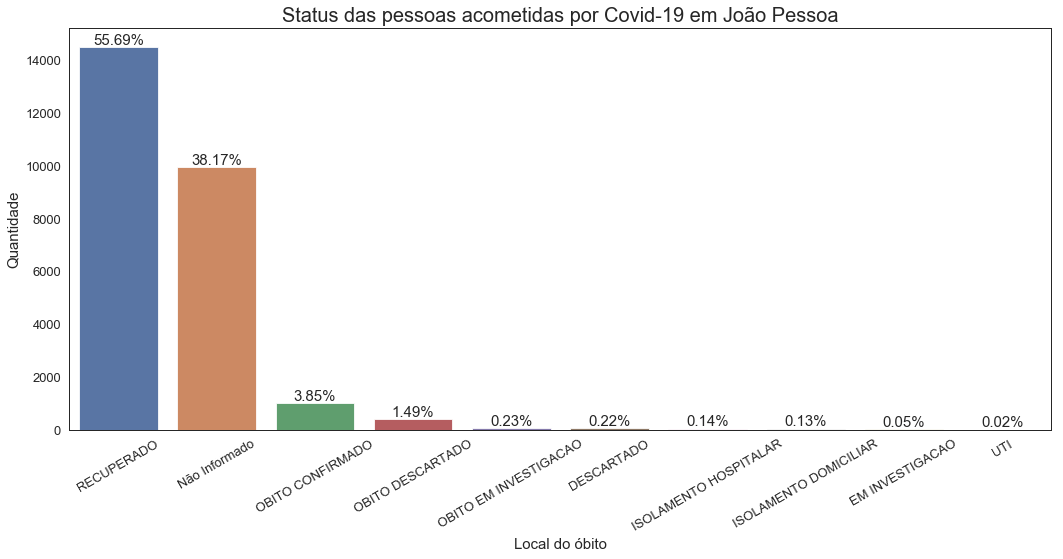

In [755]:
# Visualizando dados
graf = sns.barplot(x='STATUS_DO_PACIENTE', y = 'qnt', data=part_status)
graf.axes.set_title("Status das pessoas acometidas por Covid-19 em João Pessoa",fontsize=20) # título
graf.set_xlabel("Local do óbito",fontsize=15) # Label do eixo x
graf.set_ylabel("Quantidade",fontsize=15) # label do eixo y
graf.tick_params(labelsize=13) # tamanho dos valores dos eixos


coloca_anotacoes(graf, part_status, coluna = 'part', local = 100)

graf.set_xticklabels(graf.get_xticklabels(),rotation=30)
plt.tight_layout()


plt.savefig('Imagens\status_recuperados.png')

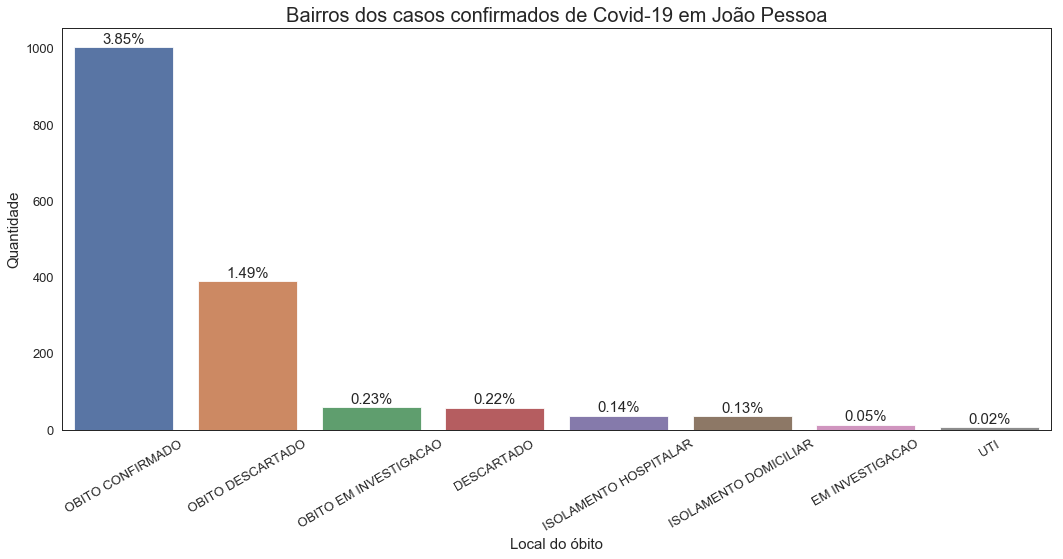

In [733]:
# Visualizando dados
graf = sns.barplot(x='STATUS_DO_PACIENTE', y = 'qnt', data=(part_status >> mask( (X.STATUS_DO_PACIENTE != 'RECUPERADO') &  (X.STATUS_DO_PACIENTE != 'Não Informado'))))
graf.axes.set_title("Bairros dos casos confirmados de Covid-19 em João Pessoa",fontsize=20) # título
graf.set_xlabel("Local do óbito",fontsize=15) # Label do eixo x
graf.set_ylabel("Quantidade",fontsize=15) # label do eixo y
graf.tick_params(labelsize=13) # tamanho dos valores dos eixos


coloca_anotacoes(graf, part_status, coluna = 'part', corrige = 2, local = 10)

graf.set_xticklabels(graf.get_xticklabels(),rotation=30)
plt.tight_layout()


plt.savefig('Imagens\status.png')

# Isolamento Domiciliar / Isolamento Hospitalar / UTI

In [734]:
hosp = df >> mask((X.STATUS_DO_PACIENTE == 'ISOLAMENTO DOMICILIAR') | (X.STATUS_DO_PACIENTE == 'UTI') | (X.STATUS_DO_PACIENTE == 'ISOLAMENTO HOSPITALAR'))

# participação
part_hosp = hosp >> group_by(X.STATUS_DO_PACIENTE) >> summarize(qnt = n(X.STATUS_DO_PACIENTE)) >> ungroup() >> mutate(part = X.qnt*100/len(df['STATUS_DO_PACIENTE']))
part_hosp['part'] = part_hosp['part'].apply(lambda x: "{:.2f}%".format(x))
part_hosp

,STATUS_DO_PACIENTE,qnt,part
0,ISOLAMENTO DOMICILIAR,35,0.13%
1,ISOLAMENTO HOSPITALAR,37,0.14%
2,UTI,6,0.02%


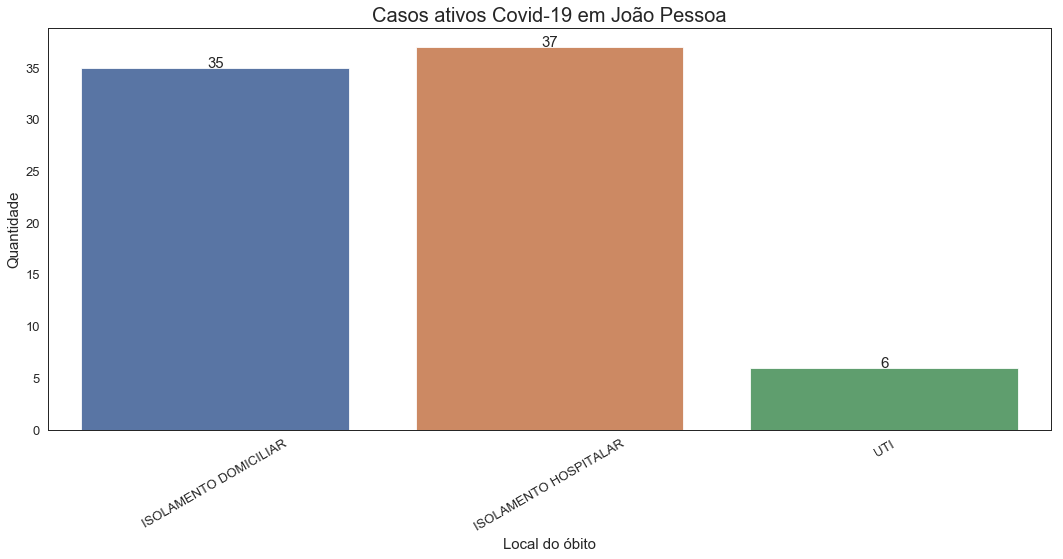

In [760]:
# Visualizando dados
graf = sns.barplot(x='STATUS_DO_PACIENTE', y = 'qnt', data=part_hosp)
graf.axes.set_title("Casos ativos Covid-19 em João Pessoa",fontsize=20) # título
graf.set_xlabel("Local do óbito",fontsize=15) # Label do eixo x
graf.set_ylabel("Quantidade",fontsize=15) # label do eixo y
graf.tick_params(labelsize=13) # tamanho dos valores dos eixos

graf.set_xticklabels(graf.get_xticklabels(),rotation=30)
plt.tight_layout()

# Coloca as anotações
coloca_anotacoes(graf, part_hosp, coluna = 'qnt')

plt.savefig('Imagens\hospitalizacoes.png')

# Idade

In [736]:
df.columns

Index(['DT_NOTIFIC', 'SE_NOTIF', 'SG_SRAG', 'DT_SIN_PRI', 'SE_SINT', 'CS_SEXO',
       'DT_NASC', 'NU_IDADE_N', 'NM_BAIRRO', 'ZONA_EPI', 'MUN_RES',
       'RESULTADO', 'STATUS_DO_PACIENTE', 'DT_OBITO'],
      dtype='object')

In [737]:
recuperados = df >> mask(X.STATUS_DO_PACIENTE == 'RECUPERADO')
mortes = df >> mask(X.STATUS_DO_PACIENTE == 'OBITO CONFIRMADO')

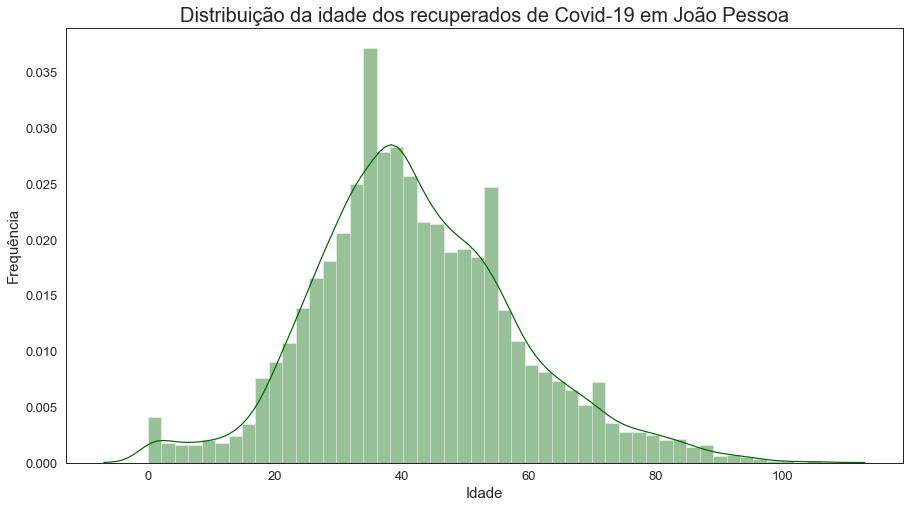

In [738]:
# Visualizando dados
graf = sns.distplot(recuperados.NU_IDADE_N, color='darkgreen')
graf.axes.set_title("Distribuição da idade dos recuperados de Covid-19 em João Pessoa",fontsize=20) # título
graf.set_xlabel("Idade",fontsize=15) # Label do eixo x
graf.set_ylabel("Frequência",fontsize=15) # label do eixo y
graf.tick_params(labelsize=13)

plt.savefig('Imagens\idade_recuperados.png')

In [751]:
recuperados.NU_IDADE_N.describe()

count    14510.000000
mean        42.287664
std         16.147298
min          0.000000
25%         32.000000
50%         41.000000
75%         52.000000
max        106.000000
Name: NU_IDADE_N, dtype: float64

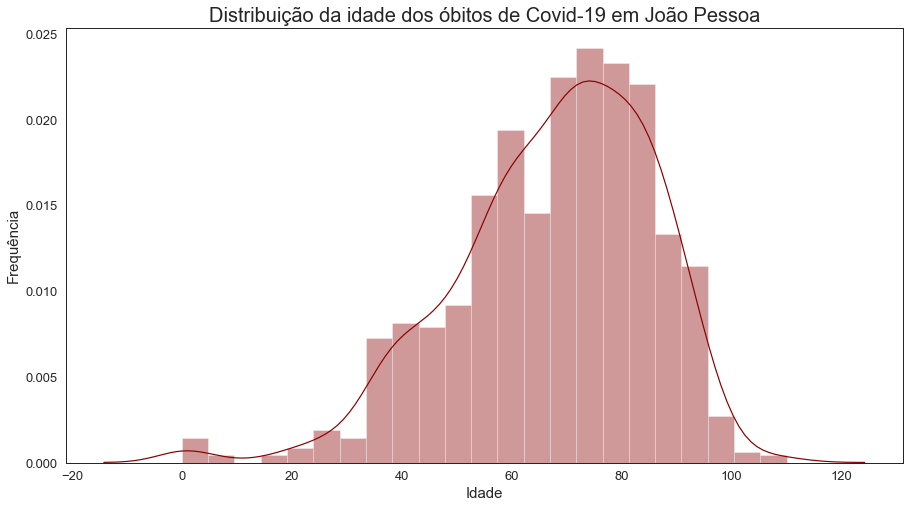

In [739]:
# Visualizando dados
graf = sns.distplot(mortes.NU_IDADE_N, color='darkred')
graf.axes.set_title("Distribuição da idade dos óbitos de Covid-19 em João Pessoa",fontsize=20) # título
graf.set_xlabel("Idade",fontsize=15) # Label do eixo x
graf.set_ylabel("Frequência",fontsize=15) # label do eixo y
graf.tick_params(labelsize=13)

plt.savefig('Imagens\idade_obito.png')

In [752]:
mortes.NU_IDADE_N.describe()

count    1004.000000
mean       67.684263
std        17.867099
min         0.000000
25%        57.000000
50%        70.000000
75%        81.000000
max       110.000000
Name: NU_IDADE_N, dtype: float64

# Bairros

In [740]:
df.head()

,DT_NOTIFIC,SE_NOTIF,SG_SRAG,DT_SIN_PRI,SE_SINT,CS_SEXO,DT_NASC,NU_IDADE_N,NM_BAIRRO,ZONA_EPI,MUN_RES,RESULTADO,STATUS_DO_PACIENTE,DT_OBITO
0,2020-06-02,23,SG,2020-05-11,20,M,04/10/2017,2,JOAO PAULO II,SUDOESTE,JOAO PESSOA,CORONAVIRUS,RECUPERADO,NaT
1,2020-07-01,27,SG,2020-06-27,26,M,07/06/1978,42,ALTO DO CEU,NOROESTE,JOAO PESSOA,CORONAVIRUS,Não Informado,NaT
2,2020-06-01,23,SRAG,2020-05-28,22,M,05/06/2006,14,BAIRRO DOS ESTADOS,NORDESTE,JOAO PESSOA,CORONAVIRUS,RECUPERADO,NaT
3,2020-05-04,19,SRAG,2020-04-25,17,M,18/05/1969,51,VARADOURO,NOROESTE,JOAO PESSOA,CORONAVIRUS,OBITO CONFIRMADO,2020-05-06
4,2020-06-12,24,SG,2020-06-12,24,F,11/02/2002,18,SAO JOSE,NORDESTE,JOAO PESSOA,CORONAVIRUS,RECUPERADO,NaT


In [741]:
df.NM_BAIRRO = df.NM_BAIRRO.fillna('Não Informado')
df.NM_BAIRRO = df.NM_BAIRRO.apply(lambda X: str(X).upper())

In [762]:
part_bairro = df >> group_by(X.NM_BAIRRO) >> summarize( qnt = n(X.NM_BAIRRO)) >> ungroup() >> arrange(X.qnt, ascending = False) >>  mutate(part = X.qnt*100/len(df['ZONA_EPI']))
part_bairro['part'] = part_bairro['part'].apply(lambda x: "{:.2f}%".format(x))
part_bairro >>= mask(X.NM_BAIRRO != 'OUTRO MUNICIPIO') >> mask(X.NM_BAIRRO != 'NÃO INFORMADO')
part_bairro.head()

,NM_BAIRRO,qnt,part
42,MANGABEIRA,2163,8.30%
20,CRISTO REDENTOR,1281,4.92%
68,VALENTINA,1174,4.51%
28,GRAMAME,1044,4.01%
40,MANAIRA,931,3.57%


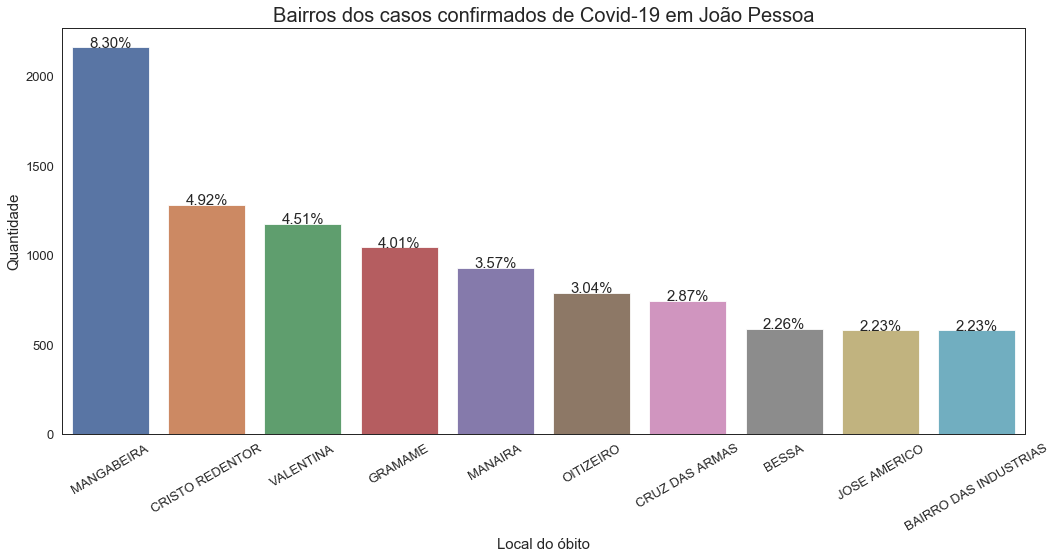

In [763]:
# Visualizando dados
graf = sns.barplot(x='NM_BAIRRO', y = 'qnt', data=part_bairro.iloc[0:10])
graf.axes.set_title("Bairros dos casos confirmados de Covid-19 em João Pessoa",fontsize=20) # título
graf.set_xlabel("Local do óbito",fontsize=15) # Label do eixo x
graf.set_ylabel("Quantidade",fontsize=15) # label do eixo y
graf.tick_params(labelsize=13) # tamanho dos valores dos eixos

graf.set_xticklabels(graf.get_xticklabels(),rotation=30)
plt.tight_layout()

# Coloca as anotações
coloca_anotacoes(graf, part_bairro, coluna = 'part')

plt.savefig('Imagens/maiores_bairro.png')

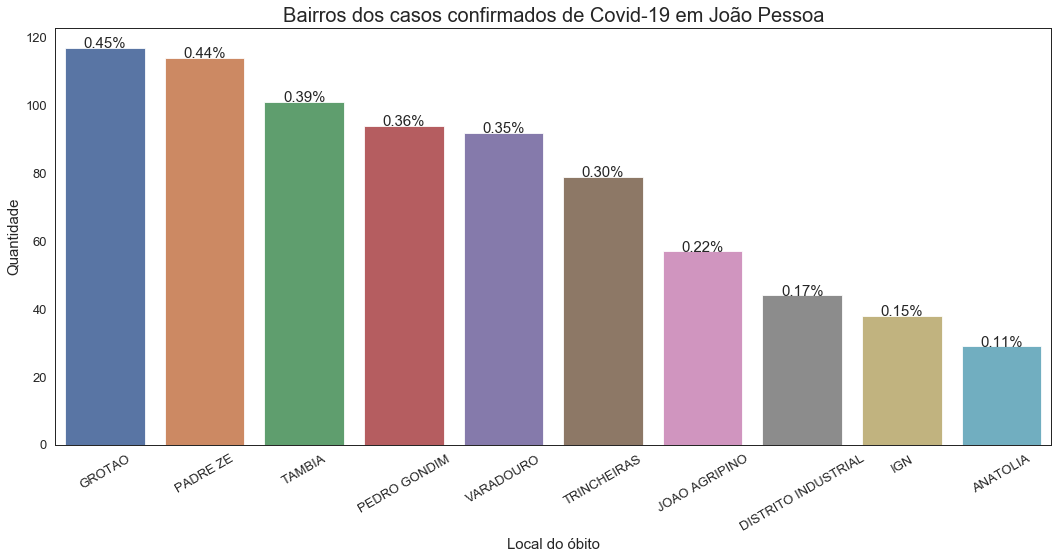

In [744]:
# Visualizando dados
graf = sns.barplot(x='NM_BAIRRO', y = 'qnt', data=part_bairro.iloc[-20:-10])
graf.axes.set_title("Bairros dos casos confirmados de Covid-19 em João Pessoa",fontsize=20) # título
graf.set_xlabel("Local do óbito",fontsize=15) # Label do eixo x
graf.set_ylabel("Quantidade",fontsize=15) # label do eixo y
graf.tick_params(labelsize=13) # tamanho dos valores dos eixos

graf.set_xticklabels(graf.get_xticklabels(),rotation=30)
plt.tight_layout()

# Coloca as anotações
coloca_anotacoes(graf, part_bairro[-20:-10], coluna = 'part')

plt.savefig('Imagens/menores_bairro.png')

## Bairros com mais pessoas em isolamento domiciliar

In [745]:
df.STATUS_DO_PACIENTE.unique()

array(['RECUPERADO', 'Não Informado', 'OBITO CONFIRMADO', 'DESCARTADO',
       'OBITO DESCARTADO', 'OBITO EM INVESTIGACAO', 'EM INVESTIGACAO',
       'ISOLAMENTO DOMICILIAR', 'ISOLAMENTO HOSPITALAR', 'UTI'],
      dtype=object)

In [746]:
isolamento_bairro = df >> mask(X.STATUS_DO_PACIENTE == 'ISOLAMENTO DOMICILIAR') >> group_by(X.NM_BAIRRO) >> summarize( qnt = n(X.NM_BAIRRO)) >> ungroup() >> arrange(X.qnt, ascending = False) >>  mutate(part = X.qnt*100/len(df['ZONA_EPI']))
isolamento_bairro['part'] = isolamento_bairro['part'].apply(lambda x: "{:.2f}%".format(x))
isolamento_bairro.head()

,NM_BAIRRO,qnt,part
0,ALTIPLANO,3,0.01%
6,CRISTO REDENTOR,3,0.01%
24,TAMBAUZINHO,2,0.01%
4,BRISAMAR,2,0.01%
20,MANGABEIRA,2,0.01%


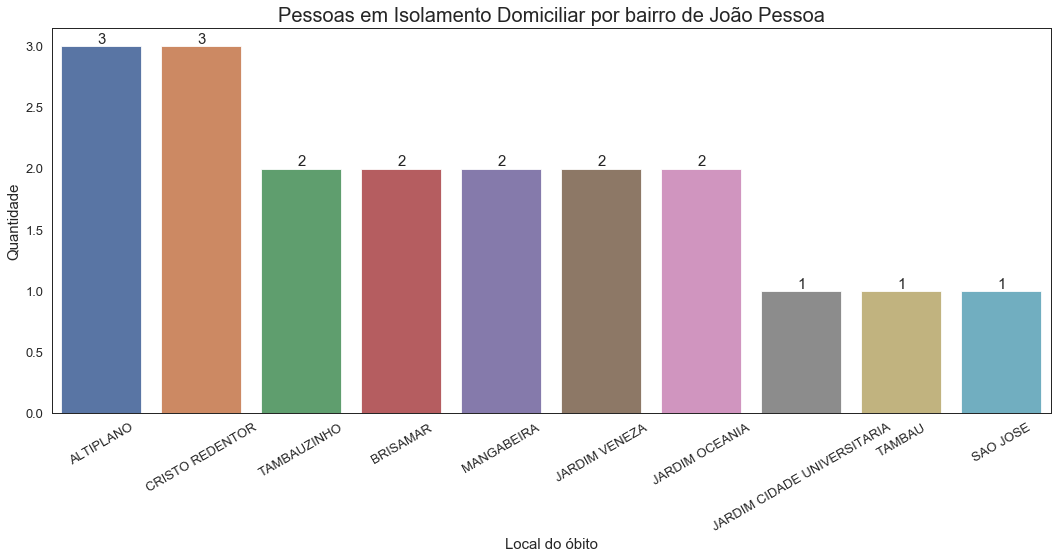

In [747]:
# Visualizando dados
graf = sns.barplot(x='NM_BAIRRO', y = 'qnt', data=isolamento_bairro.iloc[:10])
graf.axes.set_title("Pessoas em Isolamento Domiciliar por bairro de João Pessoa",fontsize=20) # título
graf.set_xlabel("Local do óbito",fontsize=15) # Label do eixo x
graf.set_ylabel("Quantidade",fontsize=15) # label do eixo y
graf.tick_params(labelsize=13) # tamanho dos valores dos eixos

graf.set_xticklabels(graf.get_xticklabels(),rotation=30)
plt.tight_layout()

# Coloca as anotações
coloca_anotacoes(graf, isolamento_bairro[:10], coluna = 'qnt', local = 0.02)

plt.savefig('Imagens/isolamento_bairro.png')

# Resultado

In [765]:
resultado_teste = df >> group_by(X.RESULTADO) >> summarize( qnt = n(X.RESULTADO)) >> ungroup() >> arrange(X.qnt, ascending = False) >>  mutate(part = X.qnt*100/len(df['ZONA_EPI']))
resultado_teste['part'] = resultado_teste['part'].apply(lambda x: "{:.2f}%".format(x))
resultado_teste.head(10)

,RESULTADO,qnt,part
0,CORONAVIRUS,22932,88.01%
2,EM INVESTIGACAO,1853,7.11%
1,DESCARTADO,1229,4.72%
5,Não Informado,39,0.15%
4,INFLUENZA B,3,0.01%
3,H1N1,1,0.00%


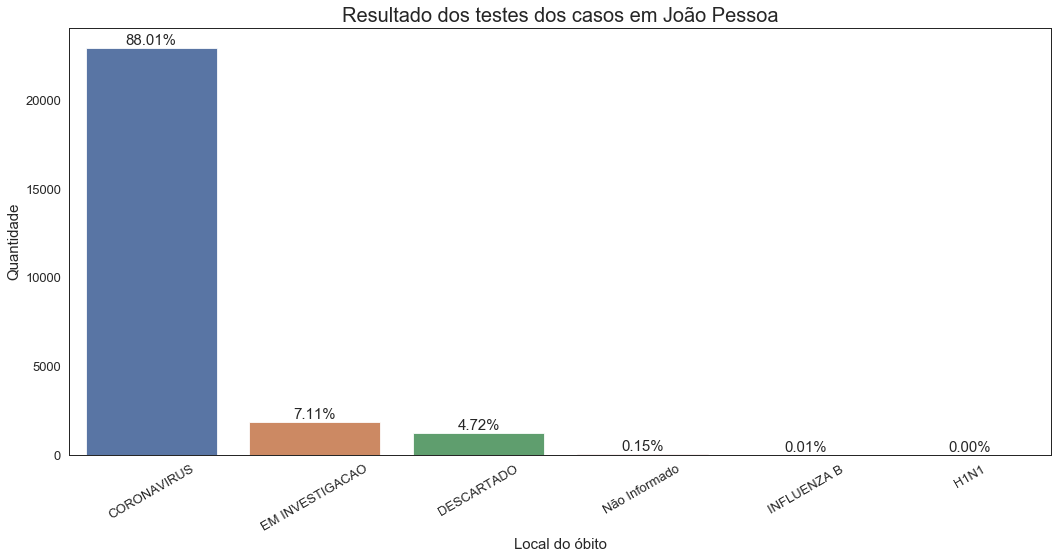

In [749]:
# Visualizando dados
graf = sns.barplot(x='RESULTADO', y = 'qnt', data=resultado_teste)
graf.axes.set_title("Resultado dos testes dos casos em João Pessoa",fontsize=20) # título
graf.set_xlabel("Local do óbito",fontsize=15) # Label do eixo x
graf.set_ylabel("Quantidade",fontsize=15) # label do eixo y
graf.tick_params(labelsize=13) # tamanho dos valores dos eixos

graf.set_xticklabels(graf.get_xticklabels(),rotation=30)
plt.tight_layout()

# Coloca as anotações
coloca_anotacoes(graf, resultado_teste, coluna = 'part', local = 200)

plt.savefig('Imagens/RESULTADO.png')